# Advanced Model-Free Control of Engineered Cells - Yeast

## Import Dependencies

In [1]:
import random

import numpy as np
import matplotlib.pyplot as plt
import torch

import pytorch_drl as drl

## Global Variants

In [2]:
SEED = 0
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

## Define Environment with Discrete Action Space

In [4]:
# reference trajectory
REF_INTENSITY = 3200

# dynamics simulator
INTENSITY_THRES = 400
PERCENTAGE_THRES = 20  # in percentage

# CRN environment
ENV = 'CRN-v0'
PARTIAL_OBSERVATION = True
TIME_AWARE = False
TOLERANCE_AWARE = False
MAX_TIMESTEPS = 72  # 12 hours
SAMPLING_RATE= 10  # in minutes
SYSTEM_NOISE = 0
OBSERVATION_NOISE = 0
ACTION_NOISE = 0

# CRN step
REWARD_FUNC = 'in_tolerance'

* Yeast dynamics model

In [5]:
dyn_simulator = drl.env.crn.YeastDynSimulator(
    intensity_thres=INTENSITY_THRES,
    percentage_thres=PERCENTAGE_THRES,
)

* Constant reference trajectory

In [6]:
ref_trajectory = drl.env.crn.ConstantRefTrajectory(
    scale=REF_INTENSITY,
)

* Define CRN environment with discrete action space `CRN-v0`

In [7]:
env = drl.env.CRNEnv(
    ENV,
    device=DEVICE,
    partial_observation=PARTIAL_OBSERVATION,
    time_aware=TIME_AWARE,
    tolerance_aware=TOLERANCE_AWARE,
    max_timesteps=MAX_TIMESTEPS,
    dyn_simulator=dyn_simulator,
    ref_trajectory=ref_trajectory,
    sampling_rate=SAMPLING_RATE,
    system_noise=SYSTEM_NOISE,
    observation_noise=OBSERVATION_NOISE,
    action_noise=ACTION_NOISE,
)

In [8]:
env.seed(SEED)

In [9]:
env.reset()

while True:
    observation, reward, done, info = env.step(
        env.action_sample, 
        reward_func=REWARD_FUNC,
    )
    if done:
        break

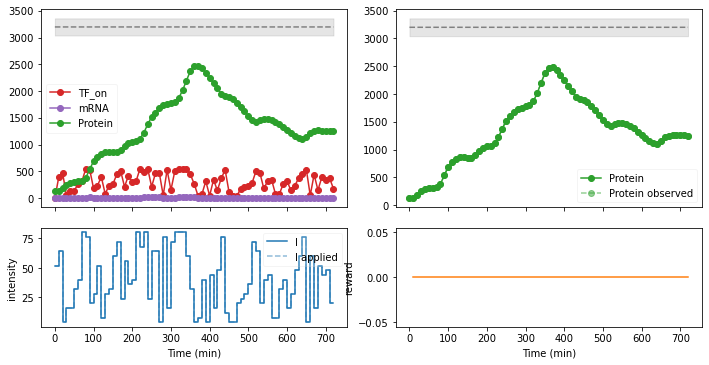

In [10]:
fig = env.render(mode='dashboard')

## Constantly Applied Light Intensity in Discrete Action Space

In [11]:
# training
EPISODES = 100
REWARD_FUNC = 'scaled_error'

### Constant Agent

* Define constant agent for discrete action space

In [12]:
actor = drl.nn.ConstantActor(
    env.action_dim,
    15,
)

agent = drl.agent.DummyAgent(
    DEVICE,
    actor,
)

### Trainer for Constant Agent

In [13]:
trainer = drl.trainer.OffPolicyTrainer(
    env, 
    agent,
    n_episodes=EPISODES,
)

### Constantly Applying

In [14]:
logger = trainer(REWARD_FUNC)

### Replay

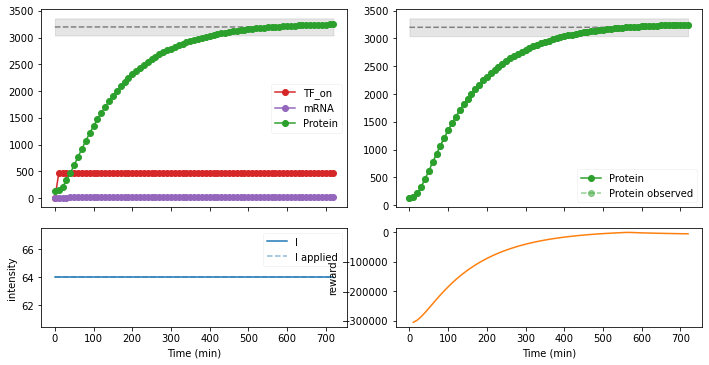

In [15]:
fig = drl.utils.plotter.replay(env, logger, episode=-1)

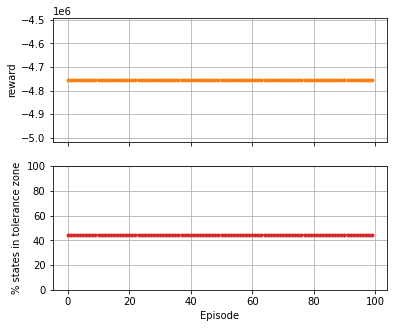

In [16]:
fig = drl.utils.plotter.plot(logger)

## Random Walking in Discrete Action Space

In [17]:
# training
EPISODES = 100
REWARD_FUNC = 'scaled_error'

### Random Agent

* Define random agent for discrete action space

In [18]:
actor = drl.nn.RandomActor(
    env.action_dim,
)

agent = drl.agent.DummyAgent(
    DEVICE,
    actor,
)

### Trainer for Random Agent

In [19]:
trainer = drl.trainer.OffPolicyTrainer(
    env, 
    agent,
    n_episodes=EPISODES,
)

### Random Walking

In [20]:
logger = trainer(REWARD_FUNC)

### Replay

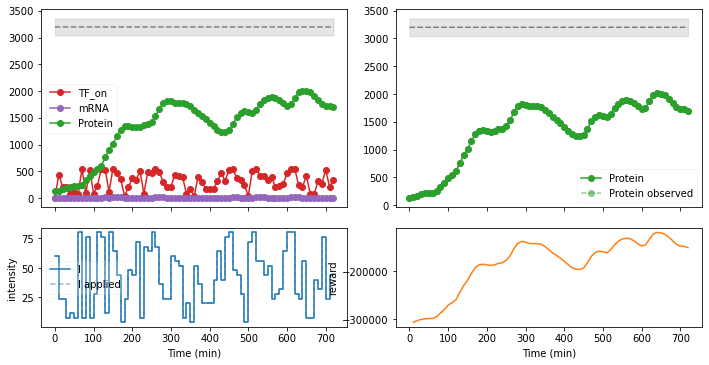

In [21]:
fig = drl.utils.plotter.replay(env, logger, episode=-1)

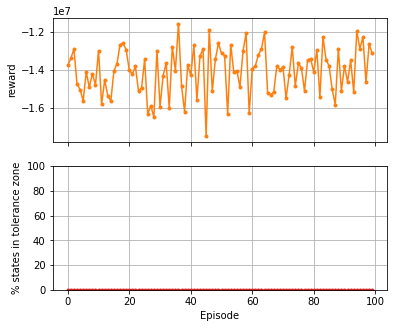

In [22]:
fig = drl.utils.plotter.plot(logger)

## Control with Q-Learning Agent for Discrete Action Space

In [23]:
# training
EPISODES = 100
REWARD_FUNC = 'scaled_error'

### Agents

* DQN agent

In [ ]:
actor = drl.nn.RandomActor(
    env.action_dim,
)

critic = drl.nn.QCritic(
    env.state_dim,
    env.action_dim,
)

agent = drl.agent.DQNAgent(
    DEVICE,
    actor,
    critic,
    exploration_rate=0.9,
    batch_size=128,
    burnin_size=16,
    learn_every=1,
    sync_every=2,
)

* DDQN agent

In [24]:
actor = drl.nn.RandomActor(
    env.action_dim,
)

critic = drl.nn.TwinQCritic(
    env.state_dim,
    env.action_dim,
    approximator_dims=(256,),
    param_sharing=False,
    hidden_dim=256,
    embedding_dims=(256,),
)

agent = drl.agent.DDQNAgent(
    DEVICE,
    actor,
    critic,
    exploration_rate=0.9,#0.99,
    batch_size=128,
    burnin_size=16,
    learn_every=2,
    sync_every=2,#4,
)

### Off-Policy Trainer for Q-learning Agent

* Define trainer for DQN family

In [25]:
bs_scheduler = drl.utils.bs_scheduler.ConstantBS(
    agent,
)

er_scheduler = drl.utils.er_scheduler.ExponentialER(
    agent,
    decay_coefficient=200,#100,
    end_er=0.05,
)

trainer = drl.trainer.OffPolicyTrainer(
    env, 
    agent,
    n_episodes=EPISODES,
    bs_scheduler=bs_scheduler,
    er_scheduler=er_scheduler,
)

### Training

In [26]:
logger = trainer(REWARD_FUNC)

### Replay

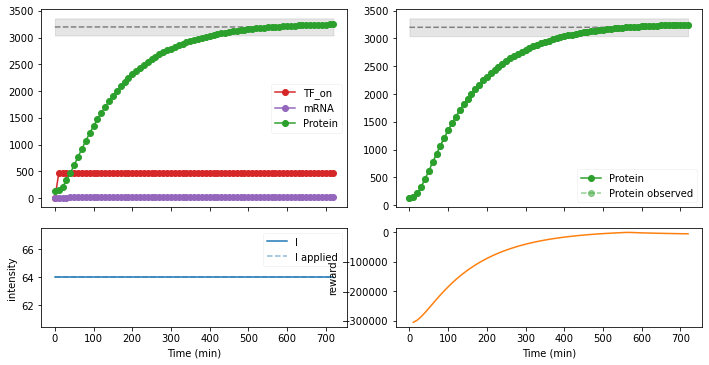

In [27]:
fig = drl.utils.plotter.replay(env, logger, episode=-1)

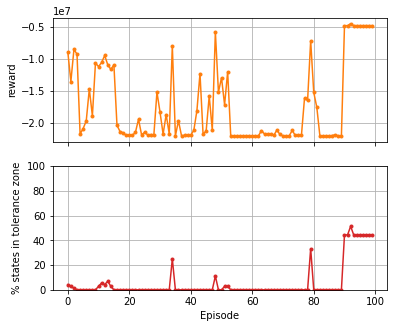

In [28]:
fig = drl.utils.plotter.plot(logger)

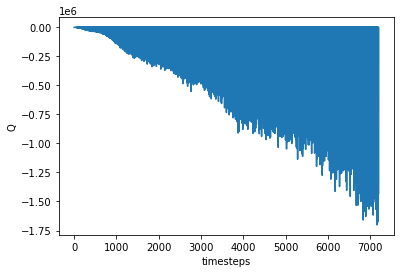

In [29]:
plt.plot(np.array(logger.episodic_Q).reshape(-1))
plt.xlabel('timesteps')
plt.ylabel('Q')
plt.show()

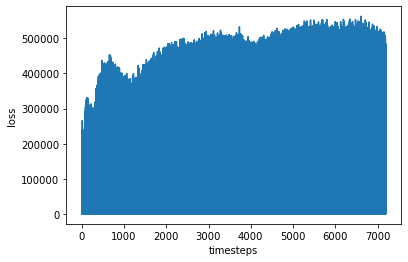

In [30]:
plt.plot(np.array(logger.episodic_critic_objective).reshape(-1))
plt.xlabel('timesteps')
plt.ylabel('loss')
plt.show()

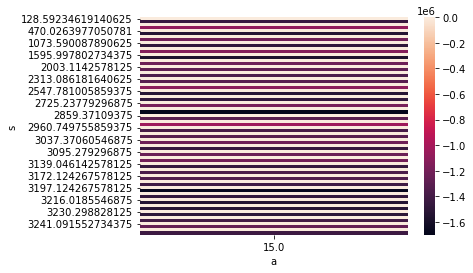

In [31]:
fig = drl.utils.plotter.heatmap(logger, episode=-1)

### Evaluation

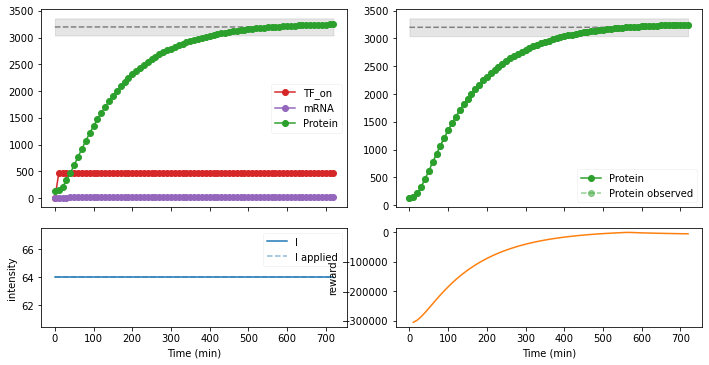

In [32]:
fig = trainer.evaluate()

## Define Environment with Continuous Action Space

In [ ]:
# reference trajectory
REF_INTENSITY = 3200

# dynamics simulator
INTENSITY_THRES = 400
PERCENTAGE_THRES = 20  # in percentage

# CRN environment
ENV = 'CRNContinuous-v0'
PARTIAL_OBSERVATION = True
TIME_AWARE = False
TOLERANCE_AWARE = False
MAX_TIMESTEPS = 60  # 10 hours
SAMPLING_RATE= 10  # in minutes
SYSTEM_NOISE = 0
OBSERVATION_NOISE = 0
ACTION_NOISE = 0

# CRN step
REWARD_FUNC = 'in_tolerance'

* Yeast dynamics model

In [ ]:
dyn_simulator = drl.env.crn.YeastDynSimulator(
    intensity_thres=INTENSITY_THRES,
    percentage_thres=PERCENTAGE_THRES,
)

* Constant reference trajectory

In [ ]:
ref_trajectory = drl.env.crn.ConstantRefTrajectory(
    scale=REF_INTENSITY,
)

* Define CRN environment with continuous action space `CRNContinuous-v0`

In [ ]:
env = drl.env.CRNEnv(
    ENV,
    device=DEVICE,
    partial_observation=PARTIAL_OBSERVATION,
    time_aware=TIME_AWARE,
    tolerance_aware=TOLERANCE_AWARE,
    max_timesteps=MAX_TIMESTEPS,
    dyn_simulator=dyn_simulator,
    ref_trajectory=ref_trajectory,
    sampling_rate=SAMPLING_RATE,
    system_noise=SYSTEM_NOISE,
    observation_noise=OBSERVATION_NOISE,
    action_noise=ACTION_NOISE,
)

In [ ]:
env.seed(SEED)

In [ ]:
env.reset()

while True:
    observation, reward, done, info = env.step(
        env.action_sample, 
        reward_func=REWARD_FUNC,
    )
    if done:
        break

In [ ]:
fig = env.render(mode='dashboard')

## Constantly Applied Light Intensity in Continuous Action Space

In [ ]:
# training
EPISODES = 100
REWARD_FUNC = 'scaled_error'

### Constant Agent

* Define constant agent for continuous action space

In [ ]:
actor = drl.nn.ContinuousConstantActor(
    env.action_dim,
    0.8,
)

agent = drl.agent.DummyAgent(
    DEVICE,
    actor,
)

### Trainer for Constant Agent

In [ ]:
trainer = drl.trainer.OffPolicyTrainer(
    env, 
    agent,
    n_episodes=EPISODES,
)

### Constantly Applying

In [ ]:
logger = trainer(REWARD_FUNC)

### Replay

In [ ]:
fig = drl.utils.plotter.replay(env, logger, episode=-1)

In [ ]:
fig = drl.utils.plotter.plot(logger)

## Random Walking in Continuous Action Space

In [ ]:
# training
EPISODES = 100
REWARD_FUNC = 'scaled_error'

### Random Agent

* Define random agent for continuous action space

In [ ]:
actor = drl.nn.ContinuousRandomActor(
    env.action_dim,
)

agent = drl.agent.DummyAgent(
    DEVICE,
    actor,
)

### Trainer for Random Agent

In [ ]:
trainer = drl.trainer.OffPolicyTrainer(
    env, 
    agent,
    n_episodes=EPISODES,
)

### Random Walking

In [ ]:
logger = trainer(REWARD_FUNC)

### Replay

In [ ]:
fig = drl.utils.plotter.replay(env, logger, episode=-1)

In [ ]:
fig = drl.utils.plotter.plot(logger)

## Control with Policy-Gradient Agent for Continuous Action Space

In [ ]:
# training
EPISODES = 100
REWARD_FUNC = 'scaled_error'

### Agents

* DDPG agent

In [ ]:
actor = drl.nn.Actor(
    env.state_dim,
    env.action_dim,
)

critic = drl.nn.Critic(
    env.state_dim,
    env.action_dim,
)

agent = drl.agent.DDPGAgent(
    DEVICE,
    actor,
    critic,
    exploration_noise=0.1,
    batch_size=128,
    burnin_size=16,
    learn_every=2,
    sync_every=1,
)

* TD3 agent

In [ ]:
actor = drl.nn.Actor(
    env.state_dim,
    env.action_dim,
)

critic = drl.nn.TwinCritic(
    env.state_dim,
    env.action_dim,
    approximator_dims=(256,),
    param_sharing=False,
    hidden_dim=256,
    embedding_dims=(256,),
)

agent = drl.agent.TD3Agent(
    DEVICE,
    actor,
    critic,
    exploration_noise=0.1,
    batch_size=128,
    burnin_size=16,
    learn_every=1,
    sync_every=4,
)

### Off-Policy Trainer for Gradient-Policy Agent

* Define trainer for DDPG family

In [ ]:
bs_scheduler = drl.utils.bs_scheduler.ConstantBS(
    agent,
)

trainer = drl.trainer.OffPolicyTrainer(
    env, 
    agent,
    n_episodes=EPISODES,
    bs_scheduler=bs_scheduler,
)

### Training

In [ ]:
logger = trainer(REWARD_FUNC)

### Replay

In [ ]:
fig = drl.utils.plotter.replay(env, logger, episode=-1)

In [ ]:
fig = drl.utils.plotter.plot(logger)

### Evaluation

In [ ]:
fig = trainer.evaluate()